## Sentiment Analysis 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

df = pd.read_csv("Tweets.csv")

In [2]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703000e+17,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2/24/2015 11:12,Los Angeles,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/2015 11:14,NaN,Pacific Time (US & Canada)


In [3]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [4]:
tweet_df = df[['text','airline_sentiment']]
print(tweet_df.shape)
tweet_df.head(5)

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica it's really aggressive to blast...,negative
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica Really missed a prime opportuni...,neutral
4,@VirginAmerica and it's a really big bad thing...,negative


In [5]:
tweet_df = tweet_df[tweet_df['airline_sentiment'] != 'neutral']
print(tweet_df.shape)
tweet_df.head(5)

(11541, 2)


,text,airline_sentiment
0,@VirginAmerica it's really aggressive to blast...,negative
1,@VirginAmerica plus you've added commercials t...,positive
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [6]:
tweet_df["airline_sentiment"].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [7]:
sentiment_label = tweet_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 0, ..., 1, 0, 0], dtype=int64),
 Index(['negative', 'positive'], dtype='object'))

In [9]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

def Cleaner(tweet_df):
    tweet_df['text'] = tweet_df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
    tweet_df['text'] = tweet_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    tweet_df['text'] = tweet_df['text'].str.replace(r'[^\w\s]+', '')
    print(tweet_df)

Cleaner(tweet_df)

<ipython-input-9-e92d6f3fd214>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet_df['text'] = tweet_df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')


                                                    text airline_sentiment
0      VirginAmerica really aggressive blast obnoxiou...          negative
1      VirginAmerica plus added commercials experienc...          positive
4                     VirginAmerica really big bad thing          negative
5      VirginAmerica seriously would pay 30 flight se...          negative
6      VirginAmerica yes nearly every time I fly VX e...          positive
...                                                  ...               ...
14633  AmericanAir flight Cancelled Flightled leaving...          negative
14634                       AmericanAir right cue delays          negative
14635     AmericanAir thank got different flight Chicago          positive
14636  AmericanAir leaving 20 minutes Late Flight No ...          negative
14638  AmericanAir money change flight answer phones ...          negative

[11541 rows x 2 columns]


<ipython-input-9-e92d6f3fd214>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet_df['text'] = tweet_df['text'].str.replace(r'[^\w\s]+', '')


In [10]:
tweet = tweet_df.text.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [11]:
print(tokenizer.word_index)

{'i': 1, 'united': 2, 'flight': 3, 'usairways': 4, 'americanair': 5, 'southwestair': 6, 'jetblue': 7, 'get': 8, 'cancelled': 9, 'thanks': 10, 'service': 11, 'you': 12, 'customer': 13, 'help': 14, 'time': 15, 'hours': 16, 'im': 17, 'hold': 18, '2': 19, 'us': 20, 'plane': 21, 'amp': 22, 'thank': 23, 'cant': 24, 'still': 25, 'delayed': 26, 'one': 27, 'flights': 28, 'gate': 29, 'call': 30, 'flightled': 31, 'hour': 32, 'back': 33, 'bag': 34, 'would': 35, 'late': 36, 'got': 37, 'no': 38, 'need': 39, 'phone': 40, 'it': 41, 'please': 42, 'airline': 43, 'now': 44, 'like': 45, 'waiting': 46, 'virginamerica': 47, 'today': 48, 'guys': 49, 'me': 50, 'great': 51, 'ive': 52, 'wait': 53, 'trying': 54, 'fly': 55, 'never': 56, '3': 57, 'day': 58, 'u': 59, 'this': 60, 'airport': 61, 'delay': 62, 'really': 63, 'minutes': 64, '4': 65, 'even': 66, 'going': 67, 'last': 68, 'people': 69, 'not': 70, 'bags': 71, 'good': 72, 'way': 73, 'know': 74, 'home': 75, 'weather': 76, 'agent': 77, 'make': 78, 'told': 79, '

In [12]:
print(tweet[0])
print(encoded_docs[0])

VirginAmerica really aggressive blast obnoxious entertainment guests faces amp little recourse
[47, 63, 3130, 3963, 3964, 883, 3131, 3965, 22, 414, 2306]


In [13]:
print(padded_sequence[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0   47   63 3130 3963 3964  883 3131
 3965 

In [14]:
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           425920    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 442,571
Trainable params: 442,571
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 [==============================] - 32s 106ms/step - loss: 0.4166 - accuracy: 0.8214 - val_loss: 0.2137 - val_accuracy: 0.9216
Epoch 2/5
289/289 [==============================] - 31s 108ms/step - loss: 0.2251 - accuracy: 0.9164 - val_loss: 0.1789 - val_accuracy: 0.9320
Epoch 3/5
289/289 [==============================] - 30s 104ms/step - loss: 0.1650 - accuracy: 0.9366 - val_loss: 0.1774 - val_accuracy: 0.9324
Epoch 4/5
289/289 [==============================] - 34s 116ms/step - loss: 0.1339 - accuracy: 0.9514 - val_loss: 0.1767 - val_accuracy: 0.9355
Epoch 5/5
289/289 [==============================] - 37s 127ms/step - loss: 0.1142 - accuracy: 0.9571 - val_loss: 0.1875 - val_accuracy: 0.9346


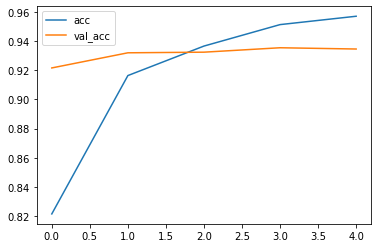

In [16]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
#plt.savefig("Accuracy plot.jpg")

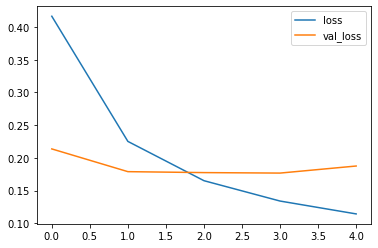

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
#plt.savefig("Loss plot.jpg")

In [18]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[0][prediction])

In [19]:
test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

Predicted label:  1
Predicted label:  0


In [21]:
df2 = pd.read_csv('teslaTweet.csv')

C:\Users\Asus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,1,21,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [22]:
df2_tweet = df2[['date','tweet']]
df2_tweet.head()

,date,tweet
0,2020-12-31,Tesla Drivers Can Now Use A Fart Noise As A Ho...
1,2020-12-31,Can somebody send me a link to the tesla truck
2,2020-12-31,"Tesla?s car horns can now fart, bark, or do wh..."
3,2020-12-31,Inversiones 2020: el peso argentino fue el gra...
4,2020-12-31,"Tesla?s car horns can now fart, bark, or do wh..."


In [23]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

def Cleaner(tweet_df):
    tweet_df['tweet'] = tweet_df['tweet'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
    tweet_df['tweet'] = tweet_df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    tweet_df['tweet'] = tweet_df['tweet'].str.replace(r'[^\w\s]+', '')
    print(tweet_df)

Cleaner(df2_tweet)

<ipython-input-23-323d8e25c200>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet_df['tweet'] = tweet_df['tweet'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
<ipython-input-23-323d8e25c200>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['tweet'] = tweet_df['tweet'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
<ipython-input-23-323d8e25c200>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

             date                                              tweet
0      2020-12-31   Tesla Drivers Can Now Use A Fart Noise As A Horn
1      2020-12-31                 Can somebody send link tesla truck
2      2020-12-31  Teslas car horns fart bark whatever else want ...
3      2020-12-31  Inversiones 2020 el peso argentino fue el gran...
4      2020-12-31  Teslas car horns fart bark whatever else want ...
...           ...                                                ...
62697  2020-06-25  Vdeo mostra como Tesla Roadster atinge 100 Kmh...
62698  2020-06-25  Tesla plans battery facility California threat...
62699  2020-06-25  See rendering upcoming Tesla Roadster speed 60...
62700  2020-06-25  Tesla gave workers permission stay home termin...
62701  2020-06-25  GONZOz Latest Conspiracy Thirst Trap Tesla The...

[62702 rows x 2 columns]


<ipython-input-23-323d8e25c200>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['tweet'] = tweet_df['tweet'].str.replace(r'[^\w\s]+', '')


In [24]:
tweet1 =df2_tweet['tweet']



In [25]:
tw = tokenizer.texts_to_sequences(tweet1)
tw = pad_sequences(tw,maxlen=200)
prediction = model.predict(tw).round()
df2_tweet['label'] = prediction

<ipython-input-25-0bc03dde5525>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_tweet['label'] = prediction


In [26]:
df2_tweet['label'].value_counts()

0.0    54326
1.0     8376
Name: label, dtype: int64

In [27]:
df2_tweet.head()

,date,tweet,label
0,2020-12-31,Tesla Drivers Can Now Use A Fart Noise As A Horn,0.0
1,2020-12-31,Can somebody send link tesla truck,0.0
2,2020-12-31,Teslas car horns fart bark whatever else want ...,0.0
3,2020-12-31,Inversiones 2020 el peso argentino fue el gran...,0.0
4,2020-12-31,Teslas car horns fart bark whatever else want ...,0.0


In [28]:
df2_tweet.to_csv('teslaWithScore3.csv')